In [1]:
import os
import platform
import random
import shutil
import sys

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.metrics
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from tqdm import tqdm_notebook as tqdm
import keras 
%matplotlib inline
random.seed(0)

from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

Using TensorFlow backend.


In [2]:
# read in train, val, test dfs 
data_dir = './data/'
# diff sheets, so need to read in 
file_name = data_dir + 'processed_binary_data' 
train_df = pd.read_csv(file_name+'_train.csv', sep = ',').reset_index()
test_df = pd.read_csv(file_name+'_test.csv', sep = ',').reset_index()
train_df.head(5)

,index,Unnamed: 0,Unnamed: 0.1,On-Target Site,Off-Target Site,Score,Encoded Seqs
0,0,0,0,AAATGAGAAGAAGAGGCACAGGG,AAAAGAGAAGCTGAGGCACAGGG,1.0,KKKREKEKKEZREKEEPKPKEEE
1,1,1,1,AAATGAGAAGAAGAGGCACAGGG,AAACGAGAAGAAGAGGCATAGGG,1.0,KKKMEKEKKEKKEKEEPKMKEEE
2,2,2,2,AAATGAGAAGAAGAGGCACAGGG,AAACGAGAAGAAGCTGCACATGG,1.0,KKKMEKEKKEKKEZJEPKPKJEE
3,3,4,4,AAATGAGAAGAAGAGGCACAGGG,AAATCATATGAAGAGGCACAAGG,1.0,KKKLHKJKREKKEKEEPKPKYEE
4,4,5,5,AAATGAGAAGAAGAGGCACAGGG,AAATGAGAAAAATAGGCAGAGGG,1.0,KKKLEKEKKYKKJKEEPKHKEEE


In [3]:
# check lengths -- confirm all are same when comparing across datasets
seq_len = len(train_df['On-Target Site'][0])
print('Guide length: ', seq_len) # NOTE: WT seq is the reverse complement of guide 
print('Off-target:', len(train_df['Off-Target Site'][0]))

Guide length:  23
Off-target: 23


In [5]:
from pysster.One_Hot_Encoder import One_Hot_Encoder

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
new_alph_map = {'AA': 'K', 'AT': 'R', 'AC': 'Z', 'AG': 'Y', 'TT': 'L', 'TC': 'M', 'TG':'J', 
                'CC': 'P', 'CG':'H', 'GG': 'E'}

new_alph = list(new_alph_map.values())
alph_len = len(new_alph)

# one-hot encode
#modified code from Luis to get correct format for TPOT w/ my alphabet
one = One_Hot_Encoder(''.join(new_alph))
    
# one-hot encode
def _get_one_hot_encoding(seq):
  """Generate one-hot encoding for a single nucleotide sequence."""
  return pd.get_dummies(
      list(seq) + new_alph)[:-len(new_alph)].as_matrix().transpose()

# now convert the data into one_hot_encoding 
input_col_name = 'Encoded Seqs'
train_data = np.stack(
    [_get_one_hot_encoding(s) for s in train_df[input_col_name]]).astype(np.float32)
#val_data = np.stack(
    #[_get_one_hot_encoding(s) for s in val_df[input_col_name]]).astype(np.float32)
test_data = np.stack(
    [_get_one_hot_encoding(s) for s in test_df[input_col_name]]).astype(np.float32)
train_data_f = np.reshape(train_data, (-1, alph_len * seq_len))
#val_data_f = np.reshape(val_data, (-1, alph_len * seq_len))
test_data_f = np.reshape(test_data, (-1, alph_len * seq_len))

/Users/kcollins/anaconda/envs/deeptoehold/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [6]:
from keras.utils import to_categorical

output_bin_col_name = 'Score'; 

# NOTE: need one-hot encoding of the labels 
train_bins = to_categorical(np.array(train_df[output_bin_col_name].astype(np.float32)))
#val_bins = to_categorical(np.array(val_df[output_bin_col_name].astype(np.float32)))
test_bins = to_categorical(np.array(test_df[output_bin_col_name].astype(np.float32)))

print('done')

done


In [7]:
from keras.layers.core import Permute
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np
import keras as keras
from keras.callbacks import TensorBoard
from keras import metrics as metrics
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Embedding
from keras.optimizers import SGD

def simple_model(hidden_layers):
    X_in = Input(shape=(seq_len*alph_len,),dtype='float32')
    H = X_in # to reset so can be passed to any hidden layer width
    for h in hidden_layers: 
        H = Dense(h, activation='relu')(H)
    H = Dense(2,activation="softmax",name='preds')(H)
    model = Model(inputs=[X_in], outputs=H)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])#[precision,recall])#metrics=[sensitivity, specificity])
    return model


In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# define k-fold cross validation test harness
num_folds = 3
num_epochs = 20
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
all_scores = {}
X = train_data_f
y = train_bins


hidden_layer_choices = [(150,50,10), (150,50),(100,30), (100,),(30,)]

for hidden_layers in hidden_layer_choices: 
    param_combo = hidden_layers
    cvscores = []
    for train, test in kfold.split(X, y.argmax(1)):
      # create model
        model = simple_model(hidden_layers=hidden_layers)
        #early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, verbose=0, mode='auto', baseline=None)
        model.fit(X[train], y[train],epochs=num_epochs, batch_size=128,verbose=0)#,callbacks=[early_stopping])
        # evaluate the model

        y_pred = model.predict(X[test])
        y_true = y[test]

        y_true_labels = np.argmax(y[test], axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1) 

        average_precision = average_precision_score(y_true, y_pred)
        auc = roc_auc_score(y_true_labels, y_pred_labels)
        acc = sklearn.metrics.accuracy_score(y_true_labels, y_pred_labels)
        f1_val = sklearn.metrics.f1_score(y_true_labels,y_pred_labels, average='macro')
        print('Average precision-recall score:', average_precision)
        print('AUC:', auc)
        print('Accuracy:', acc)
        print('F1:', f1_val)
        cvscores.append([average_precision, auc, acc, f1_val])
    all_scores[param_combo] = cvscores

Average precision-recall score: 0.8169662099448993
AUC: 0.7093413905431276
Accuracy: 0.9988168068460106
F1: 0.7765204181486074
Average precision-recall score: 0.8028326909707422
AUC: 0.766758436626653
Accuracy: 0.9986700420083283
F1: 0.7919305878028644
Average precision-recall score: 0.827903644285126
AUC: 0.7472397859628167
Accuracy: 0.9988626461820683
F1: 0.8009973053947923
Average precision-recall score: 0.8055155345927186
AUC: 0.7693257052880754
Accuracy: 0.998578333807222
F1: 0.7849625536218232
Average precision-recall score: 0.7955651084508791
AUC: 0.7562918265485218
Accuracy: 0.9986425256360868
F1: 0.784543816103584
Average precision-recall score: 0.8392494288666543
AUC: 0.7761458073907146
Accuracy: 0.9988809905984866
F1: 0.8159848812938856
Average precision-recall score: 0.8161694015370238
AUC: 0.7590198875526057
Accuracy: 0.9988718390857311
F1: 0.8081287589176678
Average precision-recall score: 0.7925164005714447
AUC: 0.6961834728924639
Accuracy: 0.9986333535120063
F1: 0.75049

In [10]:
d = pd.DataFrame.from_dict(all_scores)
d.to_csv('simple_grid_search_all.csv')

In [11]:
d

150  \
                                                  50   
                                                  10   
0  [0.8169662099448993, 0.7093413905431276, 0.998...   
1  [0.8028326909707422, 0.766758436626653, 0.9986...   
2  [0.827903644285126, 0.7472397859628167, 0.9988...   

                                                      \
                                                       
                                                 NaN   
0  [0.8055155345927186, 0.7693257052880754, 0.998...   
1  [0.7955651084508791, 0.7562918265485218, 0.998...   
2  [0.8392494288666543, 0.7761458073907146, 0.998...   

                                                 100  \
                                                  30   
                                                 NaN   
0  [0.8161694015370238, 0.7590198875526057, 0.998...   
1  [0.7925164005714447, 0.6961834728924639, 0.998...   
2  [0.8350603438228478, 0.7708826494959777, 0.998...   

                                                      \
                                                 NaN   
                                                 NaN   
0  [0.8496004109597836, 0.7564250568461813, 0.998...   
1  [0.820320466236762, 0.7276154618993109, 0.9987...   
2  [0.8346847655287988, 0.7682602587693103, 0.998...   

                                                 30   
                                                 NaN  
                                                 NaN  
0  [0.8333093286020027, 0.7511894547519404, 0.998...  
1  [0.8145305039755539, 0.7771928879323304, 0.998...  
2  [0.8348622155422898, 0.7945163248084377, 0.998...

In [12]:
cv_means = {k:sum(np.array(v)/num_folds) for k,v in all_scores.items()}

<BarContainer object of 5 artists>

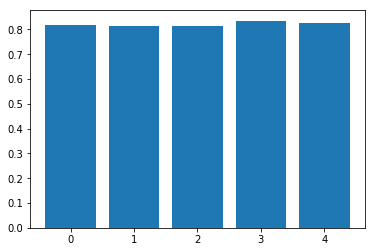

In [13]:
cv_means_df = pd.DataFrame.from_dict(cv_means)
param_combos = list(cv_means.keys())
score_vals = [cv_means[k][0] for k in param_combos]
plt.bar(range(len(param_combos)),score_vals)

In [16]:
param_combos

[(150, 50, 10), (150, 50), (100, 30), (100,), (30,)]

In [22]:
prec_recall_scores = []
for params in param_combos:
    folds = all_scores[params]
    prec_recall_scores.append([fold[0] for fold in folds])
param_combos_str = [str(params) for params in param_combos]

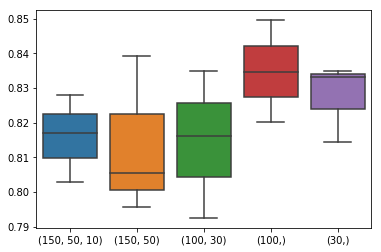

In [23]:
sns.boxplot(param_combos_str, prec_recall_scores)

In [ ]:
# best => hidden_layers = (100,)